## 実践機械学習　第７章
###7.3.1 テキストのサンプルデータ

この前の続き。
アメリカの決算報告書の10Kレポートからの株の推移予測。データは以下からダウンロードする必要あり。P>N問題の例。
http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html

wget -t inf http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/E2006.train.bz2

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

In [4]:
from sklearn.datasets import load_svmlight_file
data,target = load_svmlight_file('E2006.train')

In [3]:
print('Min target value: {}'.format(target.min()))
print('Max target value: {}'.format(target.max()))
print('Mean target value: {}'.format(target.mean()))
print('Std. dev. target value: {}'.format(target.std()))

Min target value: -7.89957807347
Max target value: -0.51940952694
Mean target value: -3.51405313669
Std. dev. target value: 0.632278353911


In [5]:
data

<16087x150360 sparse matrix of type '<type 'numpy.float64'>'
	with 19971015 stored elements in Compressed Sparse Row format>

In [6]:
target

array([-3.58943963, -3.52663816, -3.68987995, ..., -3.45833933,
       -3.76274561, -3.62727649])

In [7]:
lr = LinearRegression(fit_intercept=True)
lr.fit(data,target)
p = np.array(map(lr.predict,data))

In [17]:
p = p.ravel()
p

array([-3.58958389, -3.52625643, -3.69048942, ..., -3.45815738,
       -3.76216531, -3.62751994])

In [14]:
e = p - target
total_sq_error = np.sum(e*e)

In [16]:
rmse_train = np.sqrt(total_sq_error/len(p))
print(rmse_train)

0.00237866684485


ここでクロスバリデーションもやってみる。

In [34]:
kf = KFold(len(target),n_folds=5)
pred = np.zeros_like(target)
for train,test in kf:
    lr.fit(data[train],target[train])
    pred[test] = lr.predict(data[test])

print('[LR] RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target,pred))))
print('[LR0] R2 on testing (5 fold), {:.2}'.format(r2_score(target,pred)))

[LR] RMSE on testing (5 fold), 0.75
[LR0] R2 on testing (5 fold), -0.43


CVでのRMSEは随分大きくなった。これは過学習により起こっている。
そこで、罰則項を用いたElasticNetなどを行う。

In [30]:
from sklearn.linear_model import ElasticNet
met = ElasticNet(alpha=0.1)

kf = KFold(len(target),n_folds=5)
pred = np.zeros_like(target)
for train, test in kf:
    met.fit(data[train],target[train])
    pred[test] = met.predict(data[test])
    
print('[EN0.1] RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target,pred))))
print('[EN0.1] R2 on testing (5 fold), {:.2}'.format(r2_score(target,pred)))

[EN0.1] RMSE on testing (5 fold), 0.4
[EN0.1] R2 on testing (5 fold), 0.61


上の例では、罰則項のパラメータを自分で0.1と指定しているけど、今度は、罰則項のパラメータ推定を自動的に内部で行ってくれるElasticNetCVを使う。結構時間がかかった。

In [32]:
from sklearn.linear_model import ElasticNetCV
met = ElasticNetCV(fit_intercept=True,n_jobs=-1)
kf = KFold(len(target),n_folds=5)
for train, test in kf:
    met.fit(data[train],target[train])
    pred[test] = met.predict(data[test])

print('[EN CV] RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target,pred))))
print('[EN CV] R2 on testing (5 fold), {:.2}'.format(r2_score(target,pred)))

[EN CV] RMSE on testing (5 fold), 0.37
[EN CV] R2 on testing (5 fold), 0.65


In [35]:
met = ElasticNetCV(n_jobs=-1, l1_ratio=[.01,.05,.25,.5,.75,.95,.99])

In [40]:
kf = KFold(len(target),n_folds=5)
pred = np.zeros_like(target)
for train, test in kf:
    met.fit(data[train],target[train])
    pred[test] = met.predict(data[test])

print('[EN CV l1_ratio] RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target,pred))))
print('[EN CV l1_ratio] R2 on testing (5 fold), {:.2}'.format(r2_score(target,pred)))

[EN CV l1_ratio] RMSE on testing (5 fold), 0.37
[EN CV l1_ratio] R2 on testing (5 fold), 0.65


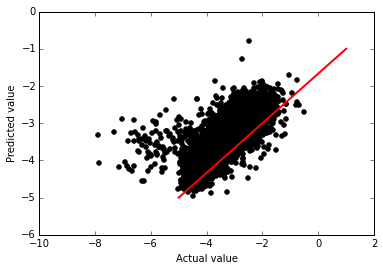

In [53]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
y = target
ax.scatter(y,pred,c='k')
ax.plot([-5,1],[-5,-1],'r-',lw=2)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
fig.savefig('Figure_10K_scatter_EN_l1_ratio.png')

ちょっと大きく描いてみる。

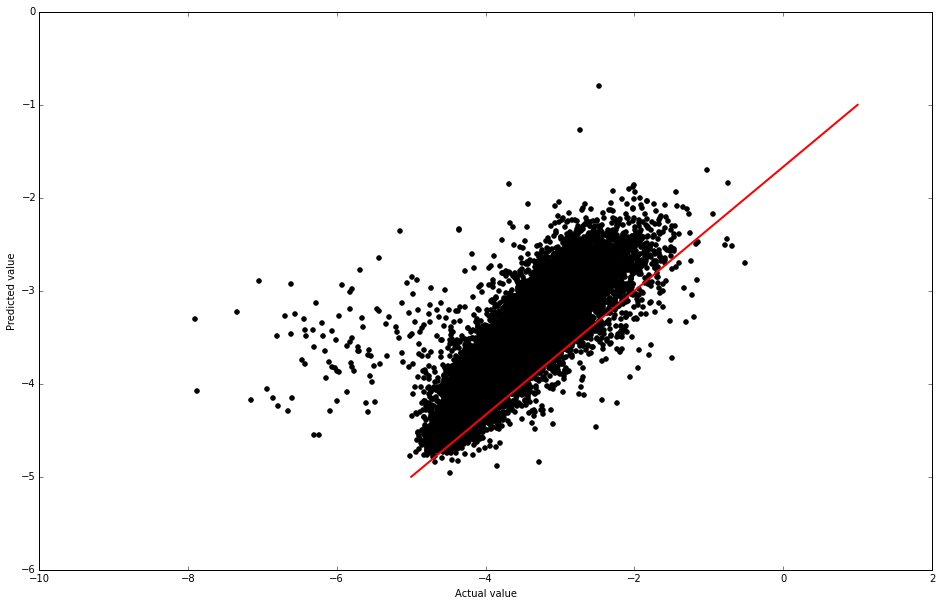

In [81]:
fig =plt.figure(figsize=(16,10))
#plt.subplots(111)
ax = fig.add_subplot(111)
y = target
plt.scatter(y,pred,c='k')
plt.plot([-5,1],[-5,-1],'r-',lw=2)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')